# North Carolina Voter Registration Analysis (Wake County)


### Requirements

- Download North Carolina voter registration database available here: https://www.ncsbe.gov/results-data/voter-registration-data
- Using the BISG implementation available here
  https://surgeo.readthedocs.io/en/dev/
- and the “weighted estimator” as described in this paper
  https://arxiv.org/pdf/1811.11154

### Task

Write code (in python preferably) to approximate the racial composition of each political party **(DEM, REP, LIB, IND)** using the weighted estimator and the BISG implementation as your proxy predictor. Do this for a county of your choosing. Also chose some appropriate visualization to show the error of your estimates and the true race proportions

### Some things to keep in mind

- You will need to do a little bit of data processing of the North Carolina voter registration dataset. Make sure that the code you write to do this is well-documented and easy to follow
- I would recommend wrapping the BISG library in a custom class since we will be implementing many other methods for prediction by proxy. Try writing a “ProxyPredictor” interface that contains an “inference” method
- Your subclass’s implementation of the “inference” method should take as input a pandas data frame, and should output a pandas data frame with race predictions
  Note: this method will not be complicated for this example, and should just interface the functionality of Surgeo (the BISG library) with the codebase that you are developing


## Download necessary packages


In [1]:
!pip install pandas
!pip install sys
!pip install os
!pip install numpy
!pip install seaborn
!pip install matplotlib
!pip install surgeo

ERROR: Could not find a version that satisfies the requirement sys (from versions: none)
ERROR: No matching distribution found for sys
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


## Download Dataset:


In [2]:
import os

datapath = "data/ncvoter92.txt"
if not os.path.exists("data"):
    os.makedirs("data")
if not os.path.isfile(datapath):
  !cd data
  !wget -O data.zip "https://s3.amazonaws.com/dl.ncsbe.gov/data/ncvoter92.zip"
  !unzip data.zip -d data
  !cd ../

zsh:1: command not found: wget
unzip:  cannot find or open data.zip, data.zip.zip or data.zip.ZIP.


## Convert into DataFrame


In [3]:
import pandas as pd
voter_data = pd.read_csv("../"+datapath, sep='\t', encoding="latin1")
print(list(voter_data.columns))
print(voter_data["last_name"].isna().sum())
print(voter_data["zip_code"].isna().sum())
voter_data.head()

['county_id', 'county_desc', 'voter_reg_num', 'ncid', 'last_name', 'first_name', 'middle_name', 'name_suffix_lbl', 'status_cd', 'voter_status_desc', 'reason_cd', 'voter_status_reason_desc', 'res_street_address', 'res_city_desc', 'state_cd', 'zip_code', 'mail_addr1', 'mail_addr2', 'mail_addr3', 'mail_addr4', 'mail_city', 'mail_state', 'mail_zipcode', 'full_phone_number', 'confidential_ind', 'registr_dt', 'race_code', 'ethnic_code', 'party_cd', 'gender_code', 'birth_year', 'age_at_year_end', 'birth_state', 'drivers_lic', 'precinct_abbrv', 'precinct_desc', 'municipality_abbrv', 'municipality_desc', 'ward_abbrv', 'ward_desc', 'cong_dist_abbrv', 'super_court_abbrv', 'judic_dist_abbrv', 'nc_senate_abbrv', 'nc_house_abbrv', 'county_commiss_abbrv', 'county_commiss_desc', 'township_abbrv', 'township_desc', 'school_dist_abbrv', 'school_dist_desc', 'fire_dist_abbrv', 'fire_dist_desc', 'water_dist_abbrv', 'water_dist_desc', 'sewer_dist_abbrv', 'sewer_dist_desc', 'sanit_dist_abbrv', 'sanit_dist_des

,county_id,county_desc,voter_reg_num,ncid,last_name,first_name,middle_name,name_suffix_lbl,status_cd,voter_status_desc,...,sanit_dist_abbrv,sanit_dist_desc,rescue_dist_abbrv,rescue_dist_desc,munic_dist_abbrv,munic_dist_desc,dist_1_abbrv,dist_1_desc,vtd_abbrv,vtd_desc
0,92,WAKE,100228366,EH906352,A,GIM,NaN,NaN,A,ACTIVE,...,NaN,NaN,NaN,NaN,UNC,UNINCORPORATED,10.0,PROSECUTORIAL DISTRICT 10,17-01,17-01
1,92,WAKE,100790131,EH1299704,A,HMIT,NaN,NaN,A,ACTIVE,...,NaN,NaN,NaN,NaN,RAL,RALEIGH,10.0,PROSECUTORIAL DISTRICT 10,17-01,17-01
2,92,WAKE,100688481,EH1232725,A,MAIH,NaN,NaN,A,ACTIVE,...,NaN,NaN,NaN,NaN,RAL,RALEIGH,10.0,PROSECUTORIAL DISTRICT 10,17-01,17-01
3,92,WAKE,100548507,EH1133682,A,MON,NaN,NaN,A,ACTIVE,...,NaN,NaN,NaN,NaN,RAL,RALEIGH,10.0,PROSECUTORIAL DISTRICT 10,17-01,17-01
4,92,WAKE,100302999,EH962486,A,RUP,NaN,NaN,A,ACTIVE,...,NaN,NaN,NaN,NaN,RAL,RALEIGH,10.0,PROSECUTORIAL DISTRICT 10,17-09,17-09


## Pre Processing:

- Removing parties other than (DEM, REP, LIB, IND)
- Mapping NC races to the BISG races
- Converting zip codes to strings

I made the choice not to remove any NA names or zip codes, as these are handled by surgeo (0% prediction for all races) and would only result in loss of information


In [4]:
import numpy as np

# Removing all parties other than  (DEM, REP, LIB, IND) -- here assume that IND(ependent) = UNA(ssigned)
voter_data = voter_data[voter_data["party_cd"].isin(
    ["DEM", "REP", "LIB", "UNA"])]
voter_parties = sorted(voter_data["party_cd"].unique())
print(voter_parties)


# Making the "race_code" and "ehnic_code" match with the surgeo's BISG race
# hispanic ethnicity takes priority over race
bisg_race = ["white", "black", "api", "native", "multiple", "hispanic"]
race_map = {"A": "multiple",
            "B": "black",
            "P": "api",
            "I": "native",
            "M": "multiple",
            "O": "multiple",
            "U": "multiple",
            "W": "white"}

voter_data["bisg_race"] = voter_data["race_code"].map(race_map)
voter_data.loc[voter_data["ethnic_code"] == "HL", "bisg_race"] = "hispanic"


# Converting zip codes to strings (NAs converted to 0)
voter_data["zip_code"] = voter_data["zip_code"].fillna(0)
voter_data["zip_code"] = voter_data["zip_code"].astype(int).astype(str)

['DEM', 'LIB', 'REP', 'UNA']


## Getting proxy race predictions (BISG)


In [5]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from predictors.BISGPredictor_class import BISGPredictor

# using BISGPredictor class
bisg = BISGPredictor()

proxy_results = bisg.inference(voter_data)
proxy_results

,zcta5,name,white,black,api,native,multiple,hispanic
0,27604,A,NaN,NaN,NaN,NaN,NaN,NaN
1,27604,A,NaN,NaN,NaN,NaN,NaN,NaN
2,27604,A,NaN,NaN,NaN,NaN,NaN,NaN
3,27604,A,NaN,NaN,NaN,NaN,NaN,NaN
4,27610,A,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
960162,NaN,ZYWICKI,NaN,NaN,NaN,NaN,NaN,NaN
960163,NaN,ZYWICKI,NaN,NaN,NaN,NaN,NaN,NaN
960164,NaN,ZYWICKI,NaN,NaN,NaN,NaN,NaN,NaN
960165,NaN,ZYWIOLEK,NaN,NaN,NaN,NaN,NaN,NaN


### Merge with the voter data with proxy race estimations


In [6]:
merged_voter_data = pd.merge(voter_data, proxy_results[bisg_race], left_index=True, right_index=True)[
    ["last_name", "zip_code", "party_cd", "bisg_race", "white", "black", "api", "native", "multiple", "hispanic"]].fillna(0)
merged_voter_data

,last_name,zip_code,party_cd,bisg_race,white,black,api,native,multiple,hispanic
0,A,27604,UNA,multiple,0.0,0.0,0.0,0.0,0.0,0.0
1,A,27604,UNA,multiple,0.0,0.0,0.0,0.0,0.0,0.0
2,A,27604,REP,multiple,0.0,0.0,0.0,0.0,0.0,0.0
3,A,27604,DEM,multiple,0.0,0.0,0.0,0.0,0.0,0.0
4,A,27610,REP,multiple,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
960162,ZYWICKI,27608,DEM,white,0.0,0.0,0.0,0.0,0.0,0.0
960163,ZYWICKI,27616,UNA,white,0.0,0.0,0.0,0.0,0.0,0.0
960164,ZYWICKI,27519,UNA,white,0.0,0.0,0.0,0.0,0.0,0.0
960165,ZYWIOLEK,27526,REP,white,0.0,0.0,0.0,0.0,0.0,0.0


## Compute weighted estimator - Racial Composition of each party
Computes the racial composition accross each party (sum(axis=0) = 1) -- [alternative below](#alternative---party-membership-for-each-race)

<img alt="Weighted Estimator Formula" src="images/weighted_estimator_formula.jpg" width = "600">


In [ ]:
# Computes (a version of?) the weighted estimate for racial party composition
estimated_party_racial_comp = {}
for party in voter_parties:
    race_dist = np.zeros(6)
    for i, race in enumerate(bisg_race):
        # To get racial composition for each party: sum of probabilities for voters of (race, party) / sum of probabitlities for voters of (party)
        race_dist[i] = merged_voter_data.loc[merged_voter_data["party_cd"] == party, race].sum(
        ) / merged_voter_data.loc[merged_voter_data["party_cd"] == party, "white":].sum().sum()
    estimated_party_racial_comp[party] = race_dist/race_dist.sum()

estimated_racial_comp = pd.DataFrame(
    estimated_party_racial_comp, index=bisg_race)
estimated_racial_comp

In [8]:
# Number of members inside each party
party_count = {}
for party in voter_parties:
    party_count[party] = len(
        merged_voter_data[merged_voter_data["party_cd"] == party])


# Computes the true racial composition of each party
actual_party_racial_comp = {}
for party in voter_parties:
    race_dist = np.zeros(6)
    for i, race in enumerate(bisg_race):
        race_dist[i] = len(merged_voter_data.loc[(merged_voter_data["party_cd"] == party) & (
            merged_voter_data["bisg_race"] == race)]) / party_count[party]
    actual_party_racial_comp[party] = race_dist

actual_racial_comp = pd.DataFrame(actual_party_racial_comp, index=bisg_race)
actual_racial_comp

,DEM,LIB,REP,UNA
white,0.443379,0.697094,0.834419,0.587115
black,0.354886,0.082459,0.021143,0.111361
api,0.000084,0.000000,0.000073,0.000087
native,0.002543,0.002586,0.001749,0.002695
multiple,0.151687,0.166438,0.114120,0.248840
hispanic,0.047420,0.051422,0.028496,0.049902


In [9]:
# Relative error
rel_error = (abs(estimated_racial_comp -
             actual_racial_comp)/actual_racial_comp)
rel_error[actual_racial_comp == 0] = 0

# Difference
difference = (estimated_racial_comp - actual_racial_comp)

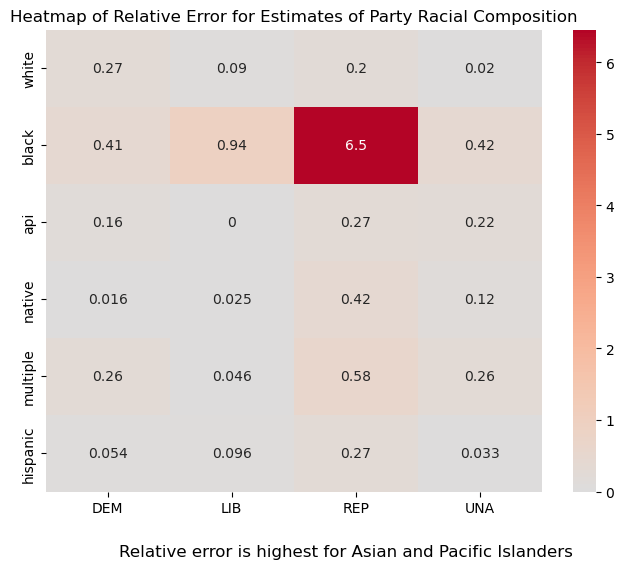

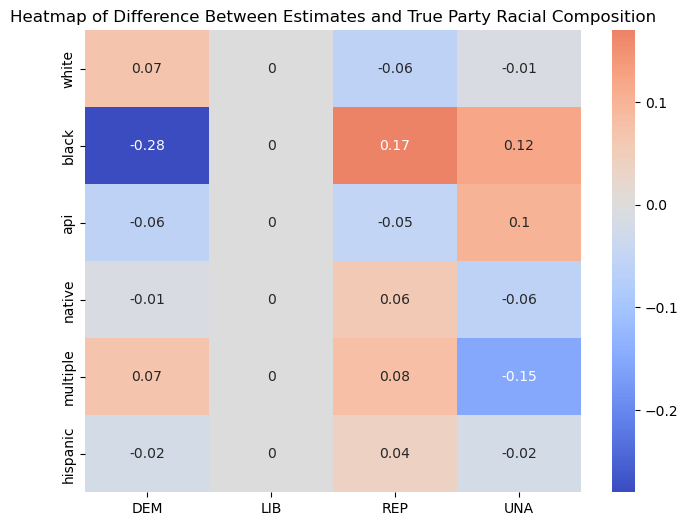

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(rel_error, annot=True, cmap="coolwarm", center=0)
plt.title("Heatmap of Relative Error for Estimates of Party Racial Composition")
plt.figtext(0.5, 0.01, 'Relative error is highest for Asian and Pacific Islanders', ha='center', va='center', fontsize=12)
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(difference.round(2).replace(-0, 0),annot=True, cmap="coolwarm", center=0)
plt.title("Heatmap of Difference Between Estimates and True Party Racial Composition")
plt.show()

## Alternative - Party membership for each race
Instead of having the racial composition of each party, this estimates the distribution of each racial group accross parties (sum(axis=1) = 1)

In [ ]:
# Sum of proxy race probabilities for each race
proba_sums = merged_voter_data.loc[:, "white":].sum().to_dict()

# Computes the weighted estimate of the racial composition of each party
estimated_party_racial_comp = {}
for party in voter_parties:
    race_dist = np.zeros(6)
    for i, race in enumerate(bisg_race):
        # To get party composition for each race: sum of probabilities for voters of (race, party) / sum of probabitlities for voters of (race)
        race_dist[i] = merged_voter_data.loc[merged_voter_data["party_cd"] == party, race].sum() / proba_sums[race]
    estimated_party_racial_comp[party] = race_dist

estimated_racial_comp = pd.DataFrame(estimated_party_racial_comp, index=bisg_race)
estimated_racial_comp

,DEM,LIB,REP,UNA
white,0.331002,0.007378,0.239967,0.421654
black,0.414028,0.006222,0.190956,0.388795
api,0.299235,0.003779,0.138828,0.558158
native,0.355689,0.007102,0.217619,0.419590
multiple,0.357076,0.006442,0.207339,0.429143
hispanic,0.349685,0.007185,0.173341,0.469789


In [12]:
# Number of members of each race group
race_count = {}
for race in bisg_race:
    race_count[race] = len(
        merged_voter_data[merged_voter_data["bisg_race"] == race])


# Computes the true racial composition of each party
actual_party_racial_comp = {}
for party in voter_parties:
    race_dist = np.zeros(6)
    for i, race in enumerate(bisg_race):
        race_dist[i] = len(merged_voter_data.loc[(merged_voter_data["party_cd"] == party) & (merged_voter_data["bisg_race"] == race)]) / race_count[race]
    actual_party_racial_comp[party] = race_dist

actual_racial_comp = pd.DataFrame(actual_party_racial_comp, index=bisg_race)
actual_racial_comp

,DEM,LIB,REP,UNA
white,0.260110,0.008110,0.301497,0.430283
black,0.697687,0.003215,0.025601,0.273498
api,0.354430,0.000000,0.189873,0.455696
native,0.361337,0.007287,0.153022,0.478354
multiple,0.282925,0.006157,0.131100,0.579818
hispanic,0.369516,0.007947,0.136761,0.485776


In [13]:
# Relative error
rel_error = (abs(estimated_racial_comp -
             actual_racial_comp)/actual_racial_comp)
rel_error[actual_racial_comp == 0] = 0

# Difference
difference = (estimated_racial_comp - actual_racial_comp)

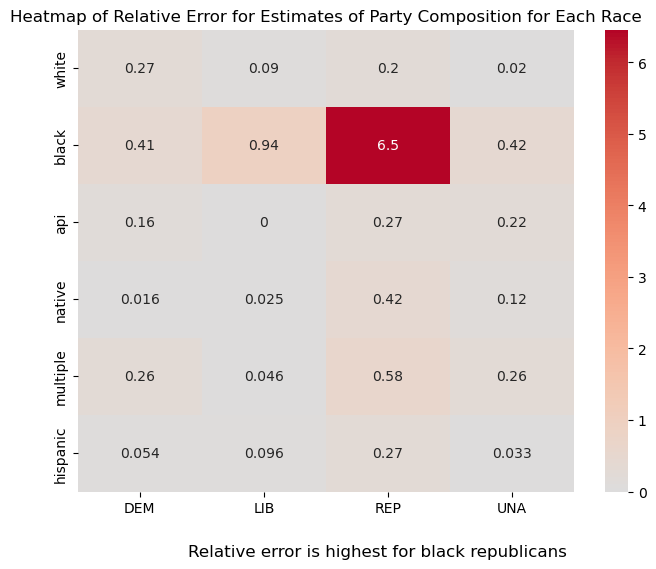

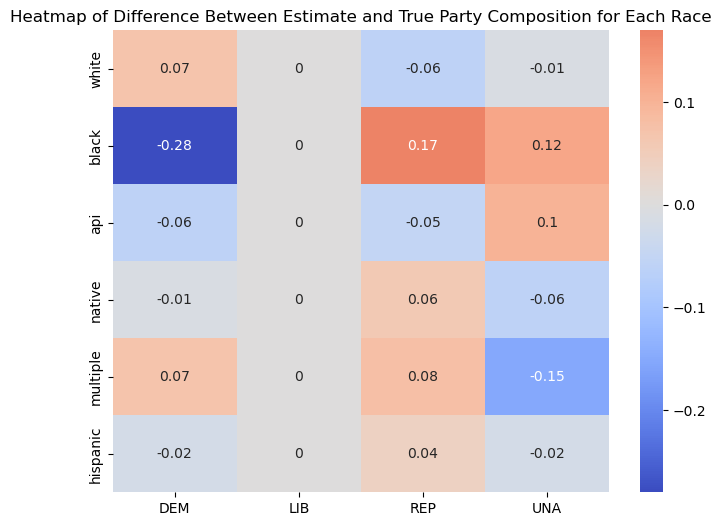

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(rel_error, annot=True, cmap="coolwarm", center=0)
plt.title("Heatmap of Relative Error for Estimates of Party Composition for Each Race")
plt.figtext(0.5, 0.01, 'Relative error is highest for black republicans', ha='center', va='center', fontsize=12)
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(difference.round(2).replace(-0, 0), annot=True, cmap="coolwarm", center=0)
plt.title("Heatmap of Difference Between Estimate and True Party Composition for Each Race")
plt.show()